In [1]:
# Importing all the necessary libraries
import keras
import h5py
from keras import optimizers
from keras.models import load_model
from keras.layers import Bidirectional
from Multimodal_baseline_Functions import *
from keras.layers import Reshape, Dropout
from keras.utils import plot_model
import os
import matplotlib.pyplot as plt
from keras.layers import Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling3D
from keras import regularizers
import seaborn as sns
import matplotlib.pyplot as plt   
from sklearn.metrics import confusion_matrix
from keras import regularizers  
from keras.applications.inception_v3 import InceptionV3

In [2]:
# Assigning class weights
class_weight = {1: 1.4,
                0: 1.}

In [3]:
GLOVE_DIR = "glove.6B"
EMBEDDING_DIM = 50
num_epochs = 7
step_epochs = 2
val_steps = 149

In [4]:
# Defining model with Adam optimizer
adam = keras.optimizers.legacy.Adam(beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
sgd = optimizers.legacy.SGD(decay=1e-6, momentum=0.9, nesterov=True)
adadelta = optimizers.legacy.Adadelta(rho=0.95, epsilon=None, decay=0.0)

In [5]:
def Image_model(base_model):
    # Freezing all the trainable layers
    for layer in base_model.layers:
        layer.trainable = False

    # Creating output layer
    x = base_model.output
    # Adding pooling layer before the output
    x = GlobalAveragePooling2D()(x)
    # Adding a fully-connected layer
    # x = Dense(1024, activation='relu')(x)
    # and a logistic layer with 2 classes
    return x

In [6]:
def read_data(file_name):
  #Opening file
    with open(file_name,'r', encoding="utf8") as f:
      #Creating empty set and dictonary for vocab and word respectively
        word_vocab = set() 
        word2vector = {}
        #Iterating over each line of file
        for line in f:
            #Spliting lines
            line_ = line.strip() 
            #Splitting words
            words_Vec = line_.split()            
            word_vocab.add(words_Vec[0])
            word2vector[words_Vec[0]] = np.array(words_Vec[1:],dtype=float)
    print("Total Words in DataSet:",len(word_vocab))
    return word_vocab,word2vector

In [7]:
# Dividing data in test, train, validation
training_DF, validation_DF, testing_DF = preprocess_text(Training_path,Validation_path, Testing_path)

In [8]:
training_DF.head()

,image_name,sentence,label
0,LJ3r8Gy.jpg.png,official bernie sanders drinking game every ti...,0
1,qDnIIHA.png,228 pm wall inside nazi gas chamber dwebs demo...,1
2,1JQk5NF.png,shit waddup bernie sanders com,1
3,iMMNq.png,mitt romney worst republican country putup bar...,0
4,jAi3iI1.png,anonymous id duqda1io 08 05 16 fri 163248 8423...,0


In [9]:
# Processing image and text for each set
# Creating train, test and validation image path
train_img_path = create_img_path(training_DF,'image_name', img_dir)
test_img_path = create_img_path(testing_DF,'image_name', img_dir)
val_img_path = create_img_path(validation_DF,'image_name', img_dir)

# Processing the text
training_DF['sentence'] = training_DF['sentence'].apply(clean_text)
testing_DF['sentence'] = testing_DF['sentence'].apply(clean_text)
validation_DF['sentence'] = validation_DF['sentence'].apply(clean_text)

In [10]:
# Vectorising text
# process the whole observation into single list
train_text_list=list(training_DF['sentence'])
test_text_list = list(testing_DF['sentence'])
val_text_list = list(validation_DF['sentence'])

# Creating vectors for train, test, validation
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(train_text_list)
sequences_train = tokenizer.texts_to_sequences(train_text_list)
sequences_test = tokenizer.texts_to_sequences(test_text_list)
sequences_val = tokenizer.texts_to_sequences(val_text_list)

x_train = preprocessing.sequence.pad_sequences(sequences_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(sequences_test, maxlen=maxlen)
x_val = preprocessing.sequence.pad_sequences(sequences_val, maxlen=maxlen)

# encoding all the labels 
y_test = testing_DF['label']
y_train = training_DF['label']
y_val = validation_DF['label']

In [11]:
# Creating train, test, val, generator for meme
img_txt_gen_train = img_text_generator(train_img_path, x_train, y_train, batch_size=32)
img_txt_gen_test = img_text_generator(test_img_path, x_test, y_test, batch_size=1)
img_txt_gen_val = img_text_generator(val_img_path, x_val, y_val, batch_size=1)

# Creating train, test, val, generator for text
txt_gen_train = text_generator(x_train, y_train, batch_size=32)
txt_gen_test = text_generator(x_test, y_test, batch_size=1)
txt_gen_val = text_generator(x_val, y_val, batch_size=1)

# Creating train, test, val, generator for image
img_gen_train = image_generator(train_img_path, training_DF, batch_size=32)
img_gen_test = image_generator(test_img_path, testing_DF, batch_size=1)
img_gen_val = image_generator(val_img_path, validation_DF, batch_size=1)

In [12]:
vocab, w2v = read_data(os.path.join(GLOVE_DIR, "glove.6B.50d.txt"))

Total Words in DataSet: 400000


In [13]:
word_index = tokenizer.word_index
num_tokens = len(word_index)

In [14]:
#Creating embeddding weight matrix
embedding_matrix = np.zeros((num_tokens + 1, EMBEDDING_DIM))

for word, i in word_index.items():
    embedding_vector = w2v.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [15]:
#Creating embedded layer using embedded matrix as weight matrix
embedding_layer = Embedding(num_tokens + 1, EMBEDDING_DIM, weights=[embedding_matrix], trainable = False)

In [16]:
from keras import regularizers

In [17]:
# Defining second LSTM
main_input = Input(shape=(maxlen,), dtype='int32', name='main_input')
# Adding embedding layer
embedded_sequences = embedding_layer(main_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
lstm1 = LSTM(32, return_state=True)
encoder_outputs,state_h,state_c = (lstm1)(x)
states= [state_h,state_c]

In [18]:
# Defining second LSTM
lstm2=LSTM(32, return_sequences=True, return_state=True)
decoder_out,_,_=lstm2(embedded_sequences,initial_state=states)
lstm_out = Flatten()(decoder_out)
txt_out = Dense(1, activation='sigmoid')(lstm_out)

In [19]:
# Defining text model
txt_model = Model(inputs = [main_input], outputs=txt_out)

In [20]:
# Compile text model
txt_model.compile(loss='binary_crossentropy', optimizer=adam, metrics = ["accuracy"])

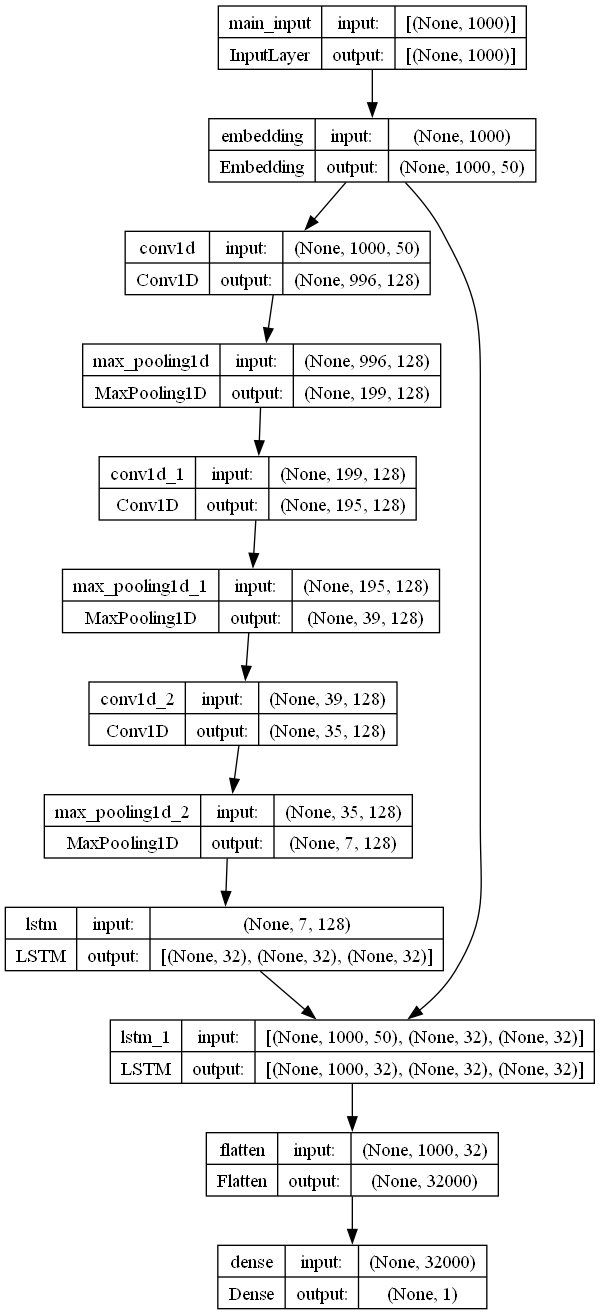

In [21]:
# Plot text model
plot_model(txt_model, to_file='CNN_txt_model.png', show_shapes=True, show_layer_names=True)

In [22]:
# Training text model
txt_model.fit_generator(txt_gen_train, epochs = 50, validation_steps = val_steps, steps_per_epoch=step_epochs, validation_data=txt_gen_val, shuffle = False, class_weight=class_weight)

Epoch 1/50


C:\Users\naman\AppData\Local\Temp\ipykernel_11240\162785797.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  txt_model.fit_generator(txt_gen_train, epochs = 50, validation_steps = val_steps, steps_per_epoch=step_epochs, validation_data=txt_gen_val, shuffle = False, class_weight=class_weight)


2/2 [==============================] - 17s 11s/step - loss: 0.8184 - accuracy: 0.4531 - val_loss: 0.7009 - val_accuracy: 0.4966
Epoch 2/50
2/2 [==============================] - 10s 10s/step - loss: 0.8016 - accuracy: 0.4844 - val_loss: 0.6816 - val_accuracy: 0.5705
Epoch 3/50
2/2 [==============================] - 10s 10s/step - loss: 0.7602 - accuracy: 0.6562 - val_loss: 0.6709 - val_accuracy: 0.6107
Epoch 4/50
2/2 [==============================] - 10s 10s/step - loss: 0.8720 - accuracy: 0.5625 - val_loss: 0.6710 - val_accuracy: 0.6107
Epoch 5/50
2/2 [==============================] - 10s 10s/step - loss: 0.8331 - accuracy: 0.5469 - val_loss: 0.6827 - val_accuracy: 0.5638
Epoch 6/50
2/2 [==============================] - 10s 10s/step - loss: 0.8018 - accuracy: 0.5312 - val_loss: 0.6945 - val_accuracy: 0.5839
Epoch 7/50
2/2 [==============================] - 10s 9s/step - loss: 0.8124 - accuracy: 0.6250 - val_loss: 0.7058 - val_accuracy: 0.4362
Epoch 8/50
2/2 [=======================

In [ ]:
# Saving text model
txt_model.save('CNN_txt_model.h5')

C:\Users\naman\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Plotting training and validation loss 
#loss_values = txt_model.history.history['loss']
#val_loss_values = txt_model.history.history['val_loss']
#epochs = range(1, 7 + 1)
#plt.plot(epochs, loss_values, 'bo', label='Training loss')
#plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
#plt.title('Training and validation loss')
#plt.xlabel('Epochs')
#plt.ylabel('Loss')
#plt.legend()
#plt.show()

In [ ]:
# Predicting labels using text model
y_pred_txt = (txt_model.predict_generator(txt_gen_test,steps = 149))
y_pred_txt = np.round(list(itertools.chain(*y_pred_txt)))
y_true = y_test.values

C:\Users\naman\AppData\Local\Temp\ipykernel_21512\1922537265.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred_txt = (txt_model.predict_generator(txt_gen_test,steps = 149))


In [ ]:
# Confusion matrix
labels = [1,0]
cm = confusion_matrix(y_true, y_pred_txt)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Greens'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['offensive', 'non-offensive']); ax.yaxis.set_ticklabels(['offensive', 'non-offensive']);
plt.show()

NameError: name 'confusion_matrix' is not defined

In [ ]:
# Loading pre-trained image model
img_model = load_model('VGG16_img_model.h5')

In [ ]:
# Compiling models
txt_model.compile(loss='binary_crossentropy', optimizer=adam, metrics = ["accuracy"])
img_model.compile(loss='binary_crossentropy', optimizer=adam, metrics = ["accuracy"])

In [ ]:
# Concatenating the output of 2 classifiers
con_layer = keras.layers.concatenate([txt_model.output, img_model.output])
out = Dense(1,activation='sigmoid')(con_layer)

In [ ]:
# Defining model input and output
com_model = Model(inputs = [img_model.input, txt_model.input], outputs=out)

In [ ]:
# compiling the combined model
com_model.compile(loss='binary_crossentropy', optimizer=adam, metrics = ["accuracy"])

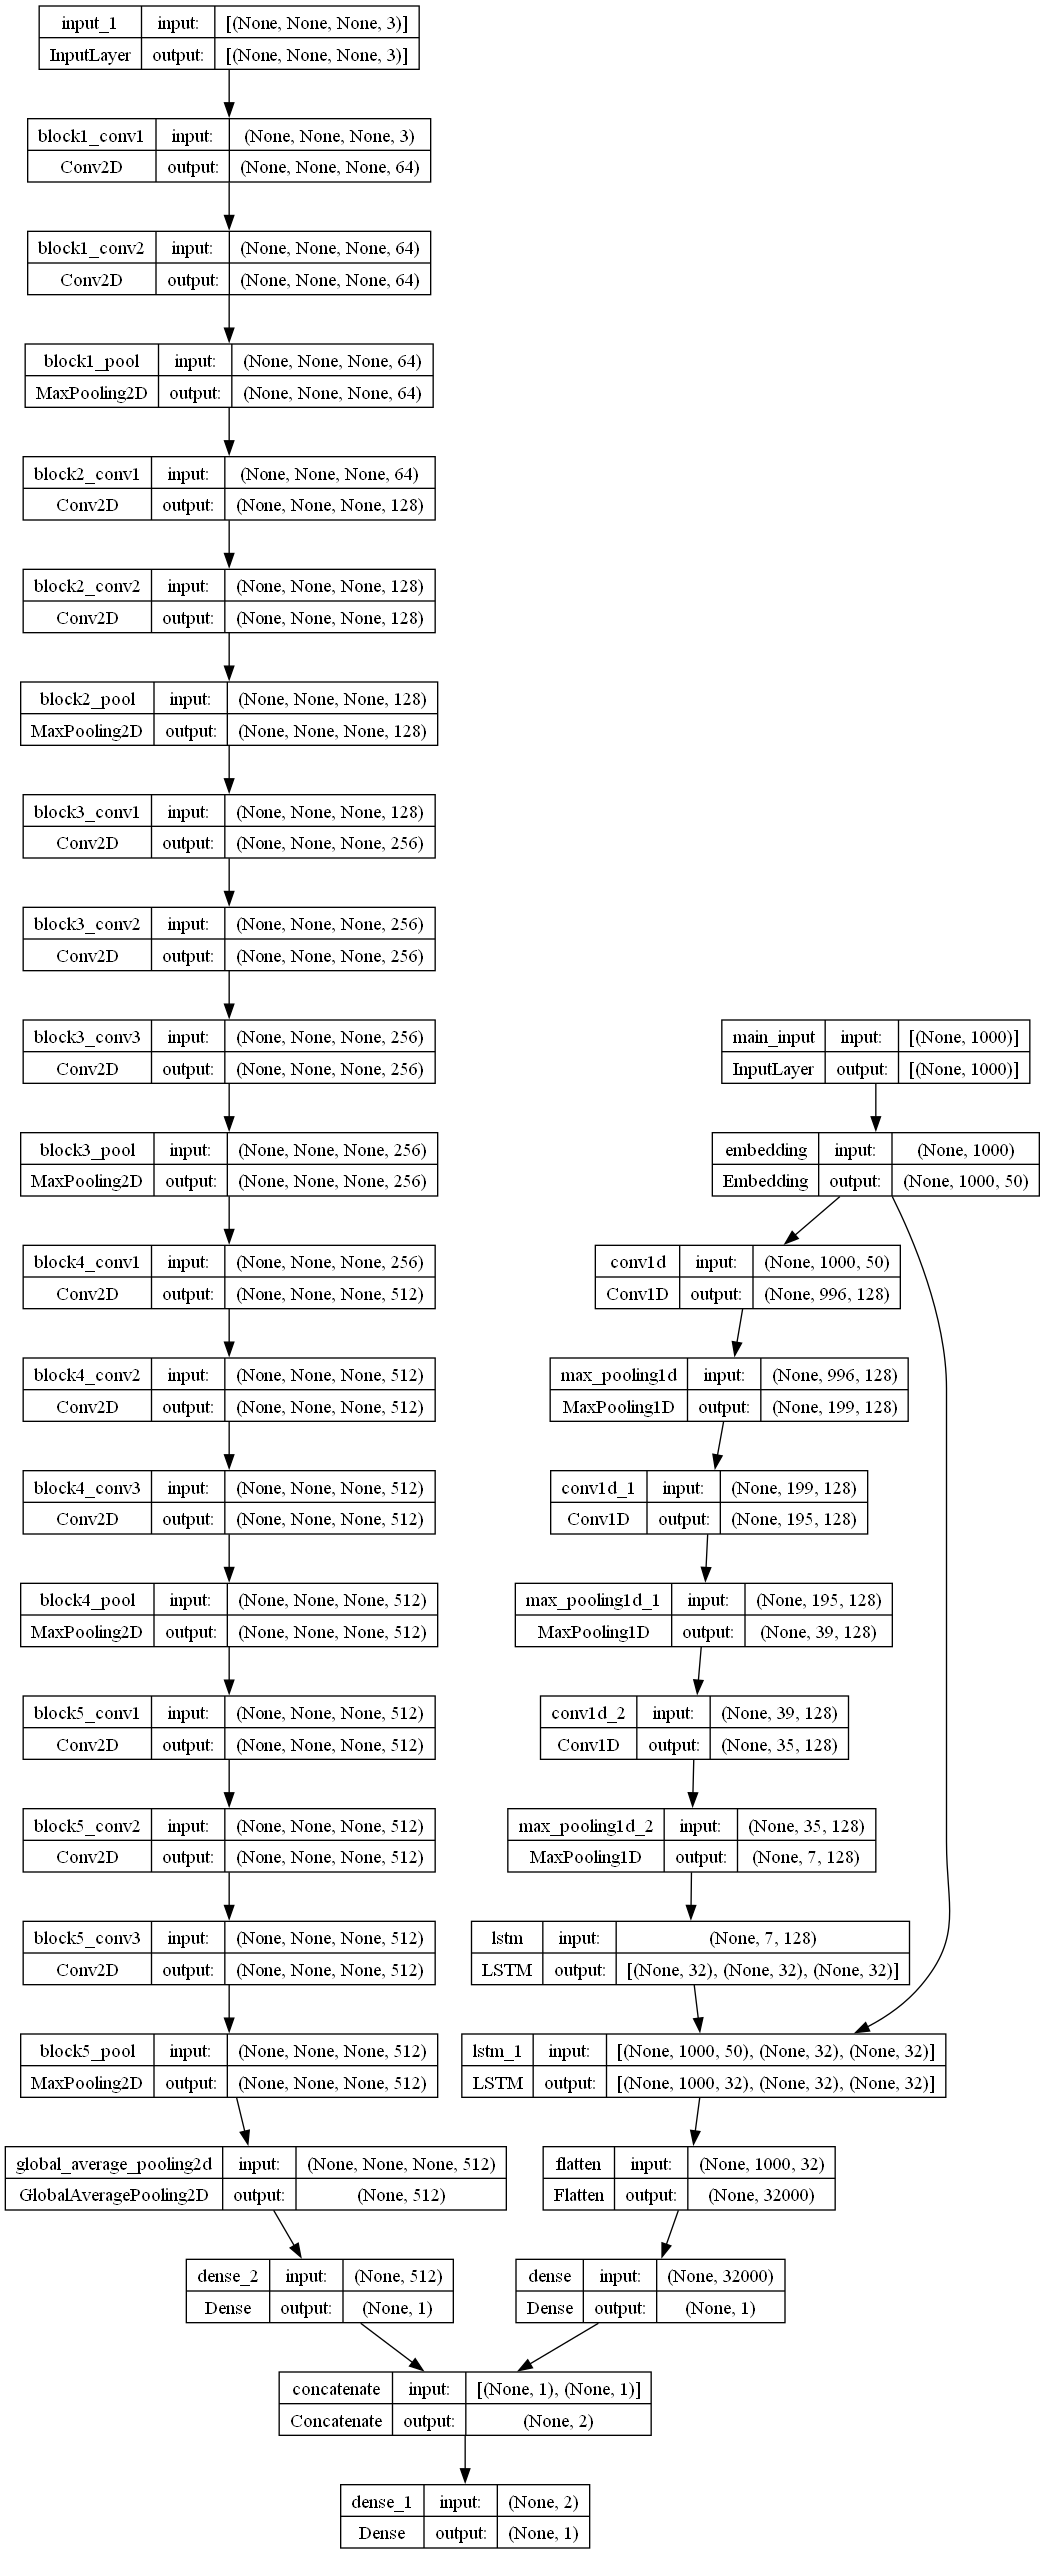

In [ ]:
# Plot model
plot_model(com_model, to_file='Two_LSTM_Inception_mul_model.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Training model
com_model.fit_generator(img_txt_gen_train, epochs=50, validation_steps = 149, steps_per_epoch=2, validation_data=img_txt_gen_val, shuffle=False, class_weight=class_weight)

C:\Users\naman\AppData\Local\Temp\ipykernel_21512\2161351252.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  com_model.fit_generator(img_txt_gen_train, epochs=50, validation_steps = 149, steps_per_epoch=2, validation_data=img_txt_gen_val, shuffle=False, class_weight=class_weight)


Epoch 1/50
2/2 [==============================] - 33s 22s/step - loss: 1.2088 - accuracy: 0.5312 - val_loss: 0.7388 - val_accuracy: 0.5906
Epoch 2/50
2/2 [==============================] - 26s 22s/step - loss: 1.1228 - accuracy: 0.6094 - val_loss: 0.7070 - val_accuracy: 0.6040
Epoch 3/50
2/2 [==============================] - 25s 22s/step - loss: 0.9359 - accuracy: 0.6406 - val_loss: 0.6994 - val_accuracy: 0.5570
Epoch 4/50
2/2 [==============================] - 25s 22s/step - loss: 0.9606 - accuracy: 0.5000 - val_loss: 0.6620 - val_accuracy: 0.6309
Epoch 5/50
2/2 [==============================] - 26s 23s/step - loss: 0.9087 - accuracy: 0.3594 - val_loss: 0.6893 - val_accuracy: 0.4966
Epoch 6/50
2/2 [==============================] - 27s 23s/step - loss: 0.8347 - accuracy: 0.5000 - val_loss: 0.7094 - val_accuracy: 0.3826
Epoch 7/50
2/2 [==============================] - 24s 21s/step - loss: 0.8656 - accuracy: 0.3906 - val_loss: 0.6906 - val_accuracy: 0.4765
Epoch 8/50
2/2 [===========

In [ ]:
# saving combined model
com_model.save("Two_LSTM_Inception_mul_model.h5")

C:\Users\naman\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Plotting training and validation loss for combined model
#loss_values = com_model.history.history['loss']
#val_loss_values = com_model.history.history['val_loss']
#epochs = range(1, num_epochs + 1)
#plt.plot(epochs, loss_values, 'bo', label='Training loss')
#plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
#plt.title('Training and validation loss')
#plt.xlabel('Epochs')
#plt.ylabel('Loss')
#plt.legend()
#plt.show()

In [ ]:
# Predicting true labels using combined classifier
y_pred_com = (com_model.predict_generator(img_txt_gen_test,steps = 149))
y_pred_com = np.round(list(itertools.chain(*y_pred_com)))

C:\Users\naman\AppData\Local\Temp\ipykernel_21512\3250972634.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred_com = (com_model.predict_generator(img_txt_gen_test,steps = 149))


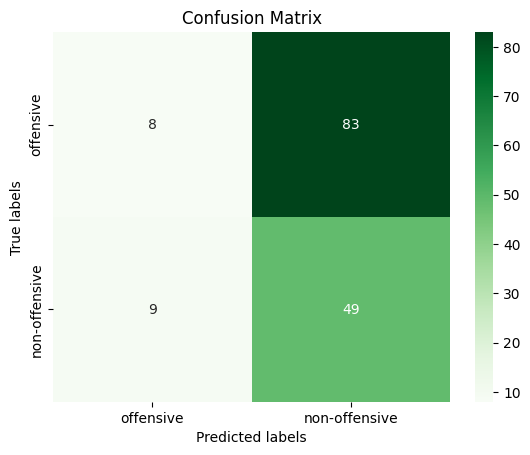

In [ ]:
# Confusion matrix
labels = [1,0]
cm = confusion_matrix(y_true, y_pred_com)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,cmap='Greens'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['offensive', 'non-offensive']); ax.yaxis.set_ticklabels(['offensive', 'non-offensive']);
# plt.figure(figsize=(5,6))

In [ ]:
# Plotting model training accuracies
#plt.plot(com_model.history.epoch, com_model.history.history['acc'])
#plt.plot(txt_model.history.epoch, txt_model.history.history['acc'])
#plt.gca().legend(('meme model acc', 'text model acc'))
#plt.xlabel('epoch')
#plt.ylabel('training accuracy')
#plt.show()

In [ ]:
# Plotting model validation accuracies
#plt.plot(com_model.history.epoch, com_model.history.history['val_acc'])
#plt.plot(txt_model.history.epoch, txt_model.history.history['val_acc'])
#plt.gca().legend(('meme model validation acc', 'text model validation acc'))
#plt.xlabel('epoch')
#plt.ylabel('validaion accuracy')
#plt.show()

In [ ]:
# Loss and accuracy for combined model
com_model.evaluate(img_txt_gen_test, steps=149)

C:\Users\naman\AppData\Local\Temp\ipykernel_21512\3343361268.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  com_model.evaluate_generator(img_txt_gen_test, steps=149)


[0.6721723675727844, 0.449664443731308]

In [ ]:
# Loss and accuracy for text model
txt_model.evaluate(txt_gen_test, steps=149)

C:\Users\naman\AppData\Local\Temp\ipykernel_21512\2907868054.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  txt_model.evaluate_generator(txt_gen_test, steps=149)


[3.131434440612793, 0.6107382774353027]

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
# for txt
precision_recall_fscore_support(y_true, y_pred_txt, beta=1.0, labels=None, pos_label=1, average='binary')

(0.5862068965517241, 0.29310344827586204, 0.3908045977011494, None)

In [ ]:
# com model
precision_recall_fscore_support(y_true, y_pred_com, beta=1.0, labels=None, pos_label=1, average='binary')

(0.3712121212121212, 0.8448275862068966, 0.5157894736842105, None)